# Data

In [3]:
import zipfile
import json
import pandas as pd
import gensim
import tqdm

In [35]:
important_wikipages = pd.read_csv("../data/interim/important_wikipages.csv", index_col=0)
print(len(important_wikipages))
important_wikipages.head()

8077


,uid,uri,freq
396690,2064,http://hu.dbpedia.org/resource/Franciaország,51508
461307,5711,http://hu.dbpedia.org/resource/Amerikai_Egyesü...,27273
424711,1145,http://hu.dbpedia.org/resource/Budapest,24992
46966,2184,http://hu.dbpedia.org/resource/Németország,23224
455783,115,http://hu.dbpedia.org/resource/Magyarország,22517


In [36]:
page_ids = set(important_wikipages.uid.values)

In [37]:
def _read_zip(zipped_wiki):
    with zipfile.ZipFile(zipped_wiki) as zf:
        for i, fname in enumerate(tqdm.tqdm(zf.namelist())):
            pid = int(fname.split(".")[0])
            if pid in page_ids:
                with zf.open(fname) as f:
                    yield json.loads(f.read())
                
# next(_read_zip("../data/interim/wik_pages.zip"))

In [51]:
def read_zip(zipped_wiki):
    df = pd.DataFrame(_read_zip(zipped_wiki))
    return df[df.content.str.len()>1000]

df = read_zip("../data/interim/wik_pages.zip")

100%|██████████| 587377/587377 [00:05<00:00, 102176.70it/s]


In [52]:
len(df)

7189

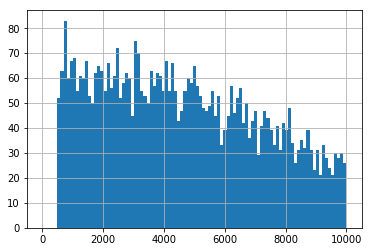

In [50]:
%matplotlib inline
#import numpy as np
#df.content.str.len().hist(bins=np.linspace(0, 10000, 100))

In [54]:
df.head()

,content,title
0,Az Omega Kossuth-díj és Liszt Ferenc-díj magya...,Omega (együttes)
1,"A Wikipédia többnyelvű , nyílt tartalmú , a ny...",Wikipédia
2,"Írható DVD ( DVD-R ) alsó , fedetlen oldala .\...",DVD
3,"A bit az információ , ugyanakkor az információ...",Bit
4,A byte ( vagy bájt ) általánosan használt táro...,Byte


# Build the model

In [55]:
import gensim
import spacy
from collections import Counter
nlp = spacy.hu.Hungarian()

In [56]:
def spacy_vectorize(text):
    return list(Counter([tok.lower for tok in nlp(text) 
            if not tok.is_stop and tok.is_alpha]).items())

spacy_vectorize("egy megy 2 nem de igen")

[(1648, 1)]

In [57]:
from collections import Counter

df["repr"] = [spacy_vectorize(text) for text in df.content.values]

In [58]:
df.head()

,content,title,repr
0,Az Omega Kossuth-díj és Liszt Ferenc-díj magya...,Omega (együttes),"[(1660, 86), (1669, 3), (1673, 32), (1675, 8),..."
1,"A Wikipédia többnyelvű , nyílt tartalmú , a ny...",Wikipédia,"[(6419, 51), (6420, 1), (5906, 4), (6421, 2), ..."
2,"Írható DVD ( DVD-R ) alsó , fedetlen oldala .\...",DVD,"[(8297, 6), (8299, 12), (8304, 1), (8305, 1), ..."
3,"A bit az információ , ugyanakkor az információ...",Bit,"[(2681, 12), (9051, 5), (5570, 1), (9052, 1), ..."
4,A byte ( vagy bájt ) általánosan használt táro...,Byte,"[(9181, 16), (9183, 1), (9283, 1), (6994, 1), ..."


In [59]:
model = gensim.models.TfidfModel(df.repr.values)

In [60]:
tfidf_corpus = model[df.repr.values]

In [68]:
from gensim.similarities import MatrixSimilarity

sim = MatrixSimilarity(tfidf_corpus)

# Test ESA

In [91]:
docs = pd.read_csv("../data/interim/merged_98_17.tsv", sep="\t")

In [111]:
test_doc = docs.iloc[4243].Text
print(test_doc)

 Elnök Asszony! Tisztelt Ház! A képviselőtársaim válaszára, amit kaptunk a minisztériumtól, körülbelül azt az összefoglalást hoznám, hogy a kormánypártoknak semmi sem drága, nem gond, ha csökken a mezőgazdasági termelés, tönkremennek jól működő társas gazdaságok, megszűnik néhány tízezer munkahely; különben is - mondta az FVM képviselője - ez csak munkaerő-piaci probléma. Éljen a család, de még inkább a nagybirtok!
Úgy látszik ez a koncepció az új birtokpolitikai irányelv, amit három évvel ezelőtt Torgyán József is megígért már, csak nem láttuk, és Orbán Viktor is néhány hónappal ezelőtt már ígért valamit. Úgy érezzük, mivel a föld politikai vita tárgya, jó lett volna, ha ezeket a birtokpolitikai elveket régóta megismerhettük volna, és kivitathattuk volna nemcsak politikai, hanem szakmai szinten is.
Megítélésünk szerint hiába van előtérbe helyezve a család a szlogenben, addig, ameddig a földből nem lehet megélni, nem teremtődik forrás a földvásárlásra, csak a spekulánsoknak, a hosszú t

In [112]:
test_bow = spacy_vectorize(test_doc)
test_tfidf = model[test_bow]

In [113]:
sim_array = sim[test_tfidf]

In [114]:
best_indices = sim_array.argsort()[-10:]

In [115]:
df.title.iloc[best_indices]

5191                                      Spárgavirágúak
4086                                         Jogtudomány
2481                                         Feudalizmus
7221                               Második Orbán-kormány
2865                                  Orbán Balázs (író)
308                                 Család (szociológia)
2476                                           Római jog
4955    Független Kisgazda-, Földmunkás- és Polgári Párt
541                                         Orbán Viktor
61                                                   Jog
Name: title, dtype: object

In [116]:
sim_array[best_indices]

array([ 0.03081835,  0.0311382 ,  0.0311594 ,  0.03410511,  0.03519953,
        0.0415751 ,  0.04638349,  0.05544276,  0.06124373,  0.07073583], dtype=float32)